# 0.Import Library

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import pi
from scipy.fftpack import fft
from scipy import stats
import pywt
import matplotlib.gridspec as gridspec
from itertools import combinations 
import sys
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, silhouette_samples


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, AgglomerativeClustering , dbscan
from sklearn.metrics import make_scorer
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler , MinMaxScaler

# 1.Load Stocks Dataset 

In [ ]:
!pip install pandas_datareader
from pandas_datareader import data as pdr
from tqdm import tqdm,trange
stock_list = ['ADVANC','AEONTS','AMATA','AOT','AP','AWC','BANPU','BBL','BCH','BCP',
            'BCPG','BDMS','BEC','BEM','BGC','BGRIM','BH','BJC','BPP','BTS',
            'CBG','CENTEL','CHG','CK','CKP','COM7','CPALL','CPF','CPN',
            'DELTA','DTAC','EA','EGCO','EPG','ERW','ESSO','GFPT','GLOBAL','GPSC',
            'GULF','GUNKUL','HANA','HMPRO','INTUCH','IRPC','IVL','JAS','JMT','KBANK',
            'KCE','KKP','KTB','KTC','LH','MAJOR','MBK','MEGA','MINT','MTC',
            'ORI','OSP','PLANB','PRM','PSH','PSL','PTG','PTT','PTTEP','PTTGC',
            'QH','RATCH','RS','SAWAD','SCB','SCC','SGP','SPALI','SPRC','STA',
            'STEC','STPI','SUPER','TASCO','TCAP','THAI','THANI','THG','TISCO','TKN',
            'TMB','TOA','TOP','TPIPP','TQM','TRUE','TTW','TU','VGI','WHA' ]
stock_data = []
stock_name = []
for quote in tqdm(stock_list):
    try:
        data = pdr.get_data_yahoo(f'{quote}.BK', start='2016-01-01', end='2019-12-31')
        stock_data.append(data)
        stock_name.append(quote)
        #data.to_csv('/content/drive/My Drive/paper IS/code stock/{:}.csv'.format(quote))
    except:
        print("Error:", sys.exc_info()[0])
        print("Description:", sys.exc_info()[1])

In [ ]:
# temp = []

# for s_data in stock_data:
#     s_data['daily_return'] = s_data[['Close']].rolling(window=2).apply(lambda x: (x[1] - x[0]) / x[0] * 100 )
#     s_data = s_data.iloc[1:, :]
#     temp.append(s_data)

# stock_data = temp

In [ ]:
mode_lenght = stats.mode([data.shape[0] for data in stock_data])[0][0]
stock_data_filtered = []
stock_list_filtered = [] 

for i in range(len(stock_list)): 
    if stock_data[i].shape[0] == mode_lenght:
        stock_data_filtered.append(stock_data[i])
        stock_list_filtered.append(stock_list[i])

display(stock_data_filtered)

In [ ]:
# Check dataset
for i in range(len(stock_list)): 
    print(i+1, stock_data[i].shape, stock_list[i])

In [ ]:
for i in range(len(stock_data_filtered)): 
    print(i+1, stock_data_filtered[i].shape, stock_list_filtered[i])

# Method 1: Short term clustering (sliding window)

# 1.Create Functions

## 1.1 Transfrom data by Wavelet transfrom

The Wavelet Transform has:

* for small frequency values a high resolution in the frequency domain,
low resolution in the time- domain,
* for large frequency values a low resolution in the frequency domain, high resolution in the time domain.

In other words, the Wavelet Transforms makes a trade-off; at scales in which time-dependent features are interesting it has a high resolution in the time-domain and at scales in which frequency-dependent features are interesting it has a high resolution in the frequency domain.


A key advantages of the Wavelet Transform are: 

*   
Wavelet transform can extract local spectral and temporal information simultaneously
*   Variety of wavelets to choose from




packages in Python: PyWavelets is one of the most comprehensive implementations for wavelet support in python for both discrete and continuous wavelets.

In [ ]:
def reshape_two_dim(np_array): 
    return np_array.reshape([1, 1, np_array.shape[0]])

def create_wavelet_row(data, waveletname, level):
    result = []
    first_coeff = []

    for i in range(level):
        widths = np.arange(1, 257)
        (data, coeff_d) = pywt.cwt(data, widths,waveletname) 
        print('data shape :',data.shape)
        list_data = data.reshape(data.shape[0]*data.shape[1])
        print('list_data shape :',list_data.shape)
        list_data = list_data.real
        # if i == 0:
        #     first_coeff = list(coeff_d)
        result += list(list_data)

    #result += first_coeff
    #print(result)
    return result

## 1.2 Custering Algorithms

In [ ]:
cal_scores = [{
      'name': 'silhouette_score',
      'fn': silhouette_score,
      'optimize': max
  },{
      'name': 'davies_bouldin_score',
      'fn': davies_bouldin_score,
      'optimize': min
  },{
      'name': 'calinski_harabasz_score',
      'fn': calinski_harabasz_score,
      'optimize': max
  }]

def find_k(X, cal_score_obj):
    score_fn = cal_score_obj['fn']
    score_optimize = cal_score_obj['optimize']
    range_n_clusters = np.arange(3,7)
    scores = []
    cluster_center = {}
    for n_clusters in range_n_clusters:
        

        def euc_dist(X, Y = None, Y_norm_squared = None, squared = False):
            return pairwise_distances(X, metric = 'correlation', n_jobs = -1)
        #     #return np.arccos(cosine_similarity(X, Y))/np.pi

        KMeans.euclidean_distances = euc_dist
        clusterer = KMeans(n_clusters=n_clusters, init='k-means++',max_iter=1000)
        clusterer = clusterer.fit(X)
        scores.append(score_fn(X, clusterer.predict(X)))
        cluster_center.update({'{}'.format(n_clusters):clusterer.cluster_centers_})
    return range_n_clusters[scores.index(score_optimize(scores))] 

def k_mean(X, cal_score_obj):
    global stock_list_filtered 
    score_fn = cal_score_obj['fn']
    X = StandardScaler().fit_transform(X)
    k = find_k(X, cal_score_obj)

    def euc_dist(X, Y = None, Y_norm_squared = None, squared = False):
        return pairwise_distances(X, metric = 'correlation', n_jobs = -1)
    #     #return np.arccos(cosine_similarity(X, Y))/np.pi

    KMeans.euclidean_distances = euc_dist

    clusters = KMeans(n_clusters = k, init='k-means++',max_iter=1000)
    clusters.fit(X)

    labels = [ [] for i in range(k)]
    for i, label in enumerate(clusters.labels_): 
        labels[label] += [stock_list_filtered[i]]
    return labels, score_fn(X, clusters.labels_)

## 1.3 Calculate score

In [ ]:
def create_wavelet(waveletname, level):
    # windows parameter
    max_data_lenght = max_lenght
    window_lenght = 90 
    window_preiod = 7
    window_ship = window_lenght - window_preiod

    # calculate dimension 
    temp = window_lenght
    first_dim = 0
    dim = 0
    for i in range(level): 
        temp = (temp+1)//2
        if i == 0: 
            first_dim = temp
        dim += temp 
    dim += first_dim 

    global stock_data_filtered
    windows_objs = []

    max_index = max_data_lenght // (window_ship) * (window_ship)
    # index_end = data_lenght 

    for index in range(0, max_index, window_ship): 
        index_start = - index - window_lenght
        index_end = - index

        wavelet_table = []

        for data_with_columns in stock_data_filtered: 
            if data_with_columns.shape[0] < -index_start: 
                continue
            data = data_with_columns['Close'][index_start:] if index == 0 else data_with_columns['Close'][index_start:index_end]
            wavelet_row = create_wavelet_row(data, waveletname, level) 
            wavelet_table += [wavelet_row]
            
        windows_obj = {} 

        for cal_score_obj in cal_scores:
            labels, score = k_mean(wavelet_table, cal_score_obj)

            windows_obj[cal_score_obj['name']] = { 
                'wavelet': wavelet_table, 
                'labels': labels,
                'score': score
            }

        windows_objs.append(windows_obj)

    # while index_start >= 0:
    #     wavelet_table = []

    #     for data_with_columns in stock_data_filtered: 
    #         data_len = data_with_columns.shape[0]
    #         if data_len < 
    #         data = data_with_columns['Adj Close'][index_start:index_end]
    #         wavelet_row = create_wavelet_row(data, waveletname, level) 
    #         wavelet_table += [wavelet_row]

    #     labels, score = k_mean(wavelet_table)

    #     windows_obj = { 
    #         'wavelet': wavelet_table, 
    #         'labels': labels,
    #         'score': score
    #     }

    #     windows_objs.append(windows_obj)

    #     # update index 
    #     index_start -= window_lenght - window_preiod
    #     index_end -= window_lenght - window_preiod
    
    windows_objs = windows_objs[::-1]

    wavelet_obj = {
        'windows': windows_objs,
    }
    for cal_score_obj in cal_scores: 
        score_name = cal_score_obj['name']
        wavelet_obj['avg_'+score_name] = sum([window[score_name]['score'] for window in windows_objs]) / len(windows_objs)

    return wavelet_obj

# 2.Prediction

In [ ]:
# wavelet parameter
level = 4
wavelet_names = ['mexh', 'morl','cmor', 'fbsp', 'shan', 'gaus1', 'gaus2', 'gaus3', 'gaus4']
wavelet_table = {}

for wavelet_name in wavelet_names: 
    wavelet_table[wavelet_name] = create_wavelet(wavelet_name, level)

# 3.Evaluate resilts

## 3.1 Aggregate result scores

In [ ]:
for wavelet_name in wavelet_names: 
    score_display = ''
    for cal_score_obj in cal_scores: 
        score_name = cal_score_obj['name']
        avg_score = wavelet_table[wavelet_name]['avg_' + score_name]
        score_display += '\t {:}: {:8.6f}'.format(score_name, avg_score)
    print('wavelet: {:7} {:}'.format(wavelet_name, score_display))

wavelet: fbsp    	 silhouette_score: 0.783772	 davies_bouldin_score: 0.289058	 calinski_harabasz_score: 664.591974


In [ ]:
for cal_score_obj in cal_scores:
    score_name = cal_score_obj['name']
    print('*'*50)
    print(score_name)
    for wavelet_name in wavelet_names:
        windows = wavelet_table[wavelet_name]['windows']
        avg_score = wavelet_table[wavelet_name]['avg_'+score_name] 
        print('='*50)
        print('wavelet: {:10} {:}: {:}'.format(wavelet_name, score_name, avg_score))
        for i, window in enumerate(windows): 
            window = window[score_name]
            print('-'*50)
            print('window {:}:'.format(i+1))
            for j, label in enumerate(window['labels']): 
                print('custer {:} have {:} stocks : {:}'.format(j+1, len(label), label))
            print('score of window: {:}.'.format(window['score']))
        print('\n\n\n')

**************************************************
silhouette_score
wavelet: fbsp       silhouette_score: 0.7837722341860519
--------------------------------------------------
window 1:
custer 1 have 7 stocks : ['ADVANC', 'AEONTS', 'BBL', 'BH', 'EGCO', 'KBANK', 'SCB']
custer 2 have 1 stocks : ['SCC']
custer 3 have 78 stocks : ['AMATA', 'AOT', 'AP', 'BANPU', 'BCH', 'BCP', 'BDMS', 'BEC', 'BEM', 'BJC', 'BTS', 'CBG', 'CENTEL', 'CHG', 'CK', 'CKP', 'COM7', 'CPALL', 'CPF', 'CPN', 'DELTA', 'DTAC', 'EA', 'EPG', 'ERW', 'ESSO', 'GFPT', 'GLOBAL', 'GPSC', 'GUNKUL', 'HANA', 'HMPRO', 'INTUCH', 'IRPC', 'IVL', 'JAS', 'JMT', 'KCE', 'KKP', 'KTB', 'KTC', 'LH', 'MAJOR', 'MBK', 'MEGA', 'MINT', 'MTC', 'ORI', 'PLANB', 'PSL', 'PTG', 'PTT', 'PTTEP', 'PTTGC', 'QH', 'RATCH', 'RS', 'SAWAD', 'SGP', 'SPALI', 'SPRC', 'STA', 'STEC', 'STPI', 'SUPER', 'TASCO', 'TCAP', 'THAI', 'THANI', 'TISCO', 'TKN', 'TMB', 'TOP', 'TRUE', 'TTW', 'TU', 'VGI', 'WHA']
score of window: 0.805521382788058.
------------------------------------

## 3.2 Ranking Score 

In [ ]:
rank_table = {}

for wavelet_name in wavelet_names: 
    rank_table[wavelet_name] = []

for cal_score_obj in cal_scores: 
    score_name = cal_score_obj['name'] 
    score_optimize = cal_score_obj['optimize']
    avg_scores = [(wavelet_name, wavelet_table[wavelet_name]['avg_' + score_name]) for wavelet_name in wavelet_names] 
    sorted_wavelet = [score_tuple[0] for score_tuple in sorted(avg_scores, key=lambda x:x[1], reverse=score_optimize==max)] 
    for index, wavelet_name in enumerate(sorted_wavelet):
        rank_table[wavelet_name].append(index) 

rank_list = [(wavelet_name, sum(rank_table[wavelet_name])) for wavelet_name in rank_table.keys()]
top_wavelet = sorted(rank_list, key=lambda x:x[1])[0][0]

In [ ]:
top_wavelet

'fbsp'

In [ ]:
new_matrix = {}
n_windows = len(wavelet_table[wavelet_names[0]]['windows'] )
n_stocks = len(stock_list_filtered)

for cal_score_obj_1 in cal_scores:
    score_name_1 = cal_score_obj_1['name']
    new_matrix[score_name_1] = {}
    for cal_score_obj_2 in cal_scores:
        score_name_2 = cal_score_obj_2['name']
        new_matrix[score_name_1][score_name_2] = np.full((n_stocks, n_stocks), 0, dtype=float)
        np.fill_diagonal(new_matrix[score_name_1][score_name_2], 1)

for cal_score_obj_1 in cal_scores:
    score_name_1 = cal_score_obj_1['name']
    for cal_score_obj_2 in cal_scores:
        score_name_2 = cal_score_obj_2['name']
        windows = wavelet_table[top_wavelet]['windows']
        for window in windows: 
            window = window[score_name_1] 
            for label in window['labels']: 
                for pair in combinations(label, 2):
                    index_i = stock_list_filtered.index(pair[0])
                    index_j = stock_list_filtered.index(pair[1]) 
                    new_matrix[score_name_1][score_name_2][index_i][index_j] += 1 / n_windows
                    new_matrix[score_name_1][score_name_2][index_j][index_i] += 1 / n_windows

# 4.Find set of similar stocks movement

In [ ]:
aaa = new_matrix['calinski_harabasz_score']['calinski_harabasz_score']

ee = 10**-10 

stock_permanente_pair = []

for i, aa in enumerate(aaa): 
    for j, a in enumerate(aa):
        if a > 1 - ee and a < 1 + ee and i != j:
            stock_permanente_pair.append([stock_list_filtered[i], stock_list_filtered[j]]) 

custers = [[]]

def find_custer_index(stock): 
    for index, custer in enumerate(custers):
        if stock in custer: 
            return index
    return -1    
    
for pair in stock_permanente_pair: 
    stock_1, stock_2 = pair 
    custer_index_1 = find_custer_index(stock_1)
    custer_index_2 = find_custer_index(stock_2)
    if custer_index_1 != -1 :
        if stock_2 not in custers[custer_index_1]:
            custers[custer_index_1].append(stock_2)
    elif custer_index_2 != -1 :
        if stock_1 not in custers[custer_index_2]:
            custers[custer_index_2].append(stock_1)
    else: 
        custers.append([stock_1, stock_2])

custers[1:]

In [ ]:
import pandas as pd
df = pd.DataFrame(new_matrix['calinski_harabasz_score']['calinski_harabasz_score'])
# df.to_csv('path/FileName.csv', index = False)

# Method 2: Long term

## 1.Create Functions

In [ ]:
cal_scores = [{
      'name': 'silhouette_score',
      'fn': silhouette_score,
      'optimize': max
  },{
      'name': 'davies_bouldin_score',
      'fn': davies_bouldin_score,
      'optimize': min
  },{
      'name': 'calinski_harabasz_score',
      'fn': calinski_harabasz_score,
      'optimize': max
  }]

def find_k(X, cal_score_obj):
    score_fn = cal_score_obj['fn']
    score_optimize = cal_score_obj['optimize']
    range_n_clusters = np.arange(3,7)
    scores = []
    cluster_center = {}
    for n_clusters in range_n_clusters:
        # parameter of affinity : euclidean , minkowski , cityblock , seuclidean, sqeuclidean, cosine , correlation, jaccard, chebyshev
        # parameter of linkage : single , complete, average, weighted, centroid, ward
        clusterer = AgglomerativeClustering(n_clusters=n_clusters , affinity='correlation', linkage='average')
        clusterers = clusterer.fit_predict(X)

        scores.append(score_fn(X, clusterer.fit_predict(X)))
        #cluster_center.update({'{}'.format(n_clusters):clusterer.cluster_centers_})
    return range_n_clusters[scores.index(score_optimize(scores))] 

def Agglomerative_Clusterings_part2(X, cal_score_obj):
    global stock_list_filtered 
    score_fn = cal_score_obj['fn']
    #from sklearn.preprocessing import StandardScaler , MinMaxScaler
    X = MinMaxScaler().fit_transform(X)
    k = find_k(X, cal_score_obj)

    clusters = AgglomerativeClustering(n_clusters = k, affinity='correlation', linkage='average')
    clusters.fit(X)

    labels = [ [] for i in range(k)]
    for i, label in enumerate(clusters.labels_): 
        labels[label] += [stock_list_filtered[i]]
    return labels, score_fn(X, clusters.labels_)

## 2.Clustering Long term

In [ ]:
all_windows = {}

for cal_score_obj_1 in cal_scores:
    score_name_1 = cal_score_obj_1['name']
    all_windows[score_name_1] = {}
    for cal_score_obj_2 in cal_scores:
        score_name_2 = cal_score_obj_2['name']
        labels, score = Agglomerative_Clusterings_part2(new_matrix[score_name_1][score_name_2], cal_score_obj_2)
        all_windows[score_name_1][score_name_2] = {
            'labels': labels,
            'score': score
        }

## 3.Evaluation results

In [ ]:
print('wavelet: {:}.\n\n'.format(top_wavelet))

for cal_score_obj_1 in cal_scores:
    score_name_1 = cal_score_obj_1['name']
    print('='*50)
    print(score_name_1)
    for cal_score_obj_2 in cal_scores:
        score_name_2 = cal_score_obj_2['name']
        all_window = all_windows[score_name_1][score_name_2]
        print('-'*50)
        print('score method: {:10}, score: {:}'.format(score_name_2, all_window['score']))
    print('\n')

wavelet: fbsp.


silhouette_score
--------------------------------------------------
score method: silhouette_score, score: 0.9611770275017689
--------------------------------------------------
score method: davies_bouldin_score, score: 0.0028412172681610004
--------------------------------------------------
score method: calinski_harabasz_score, score: 14180.929416564662


davies_bouldin_score
--------------------------------------------------
score method: silhouette_score, score: 0.9459290467316778
--------------------------------------------------
score method: davies_bouldin_score, score: 0.0890131451674732
--------------------------------------------------
score method: calinski_harabasz_score, score: 7762.037637041403


calinski_harabasz_score
--------------------------------------------------
score method: silhouette_score, score: 0.6975778763934917
--------------------------------------------------
score method: davies_bouldin_score, score: 0.43051635710924036
----------------

In [ ]:
print('wavelet: {:}.\n\n'.format(top_wavelet))

for cal_score_obj_1 in cal_scores:
    score_name_1 = cal_score_obj_1['name']
    print('='*50)
    print(score_name_1)
    for cal_score_obj_2 in cal_scores:
        score_name_2 = cal_score_obj_2['name']
        all_window = all_windows[score_name_1][score_name_2]
        print('-'*50)
        print('score method: {:10}, score: {:}'.format(score_name_2, all_window['score']))
        for i, label in enumerate(all_window['labels']): 
            print('custer {:} have {:} stocks : {:}'.format(i+1, len(label), label))
    print('\n')

wavelet: fbsp.


silhouette_score
--------------------------------------------------
score method: silhouette_score, score: 0.9611770275017689
custer 1 have 7 stocks : ['ADVANC', 'AEONTS', 'BBL', 'BH', 'EGCO', 'KBANK', 'SCB']
custer 2 have 77 stocks : ['AMATA', 'AOT', 'AP', 'BANPU', 'BCH', 'BCP', 'BDMS', 'BEC', 'BEM', 'BJC', 'BTS', 'CBG', 'CENTEL', 'CHG', 'CK', 'CKP', 'COM7', 'CPALL', 'CPF', 'CPN', 'DELTA', 'DTAC', 'EA', 'EPG', 'ERW', 'ESSO', 'GFPT', 'GLOBAL', 'GPSC', 'GUNKUL', 'HANA', 'HMPRO', 'INTUCH', 'IRPC', 'IVL', 'JAS', 'JMT', 'KCE', 'KKP', 'KTB', 'KTC', 'LH', 'MAJOR', 'MBK', 'MEGA', 'MINT', 'MTC', 'ORI', 'PLANB', 'PSL', 'PTG', 'PTT', 'PTTGC', 'QH', 'RATCH', 'RS', 'SAWAD', 'SGP', 'SPALI', 'SPRC', 'STA', 'STEC', 'STPI', 'SUPER', 'TASCO', 'TCAP', 'THAI', 'THANI', 'TISCO', 'TKN', 'TMB', 'TOP', 'TRUE', 'TTW', 'TU', 'VGI', 'WHA']
custer 3 have 1 stocks : ['SCC']
custer 4 have 1 stocks : ['PTTEP']
--------------------------------------------------
score method: davies_bouldin_score, sc

In [ ]:
all_window['labels']

## 4.Plot results

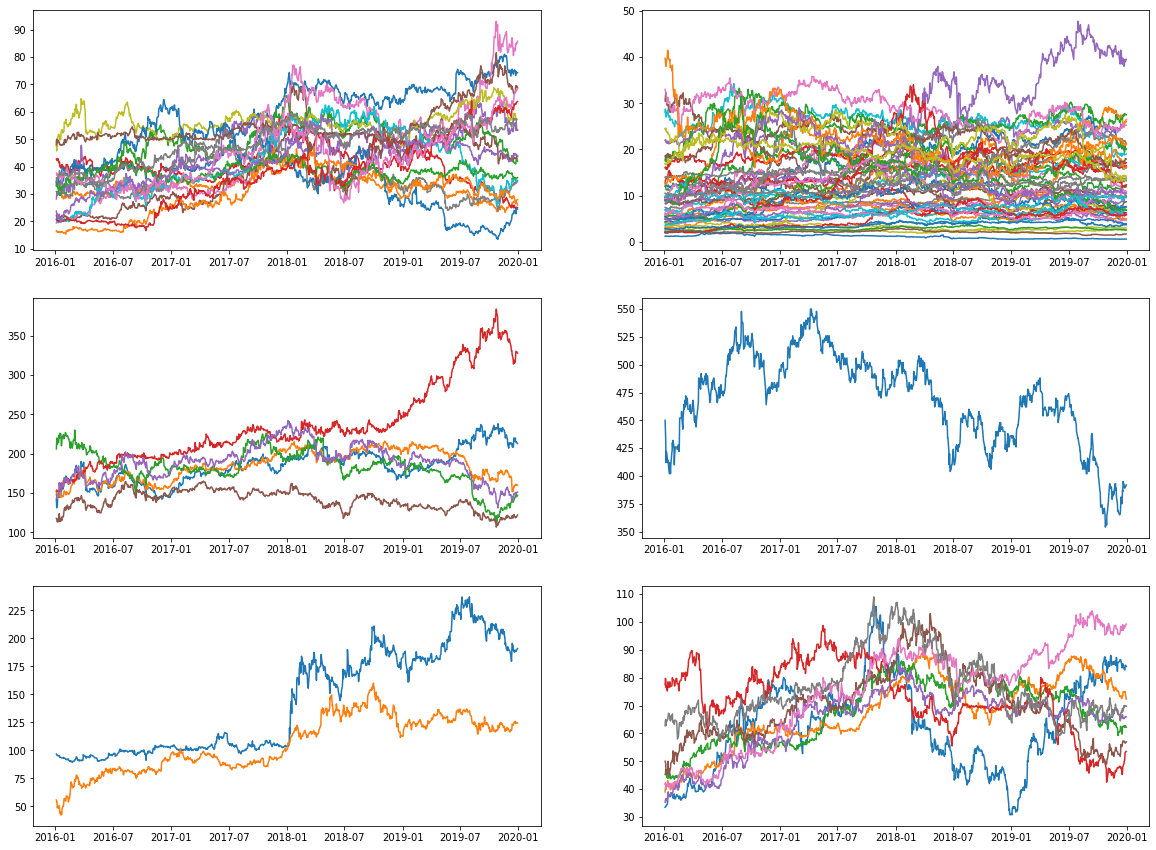

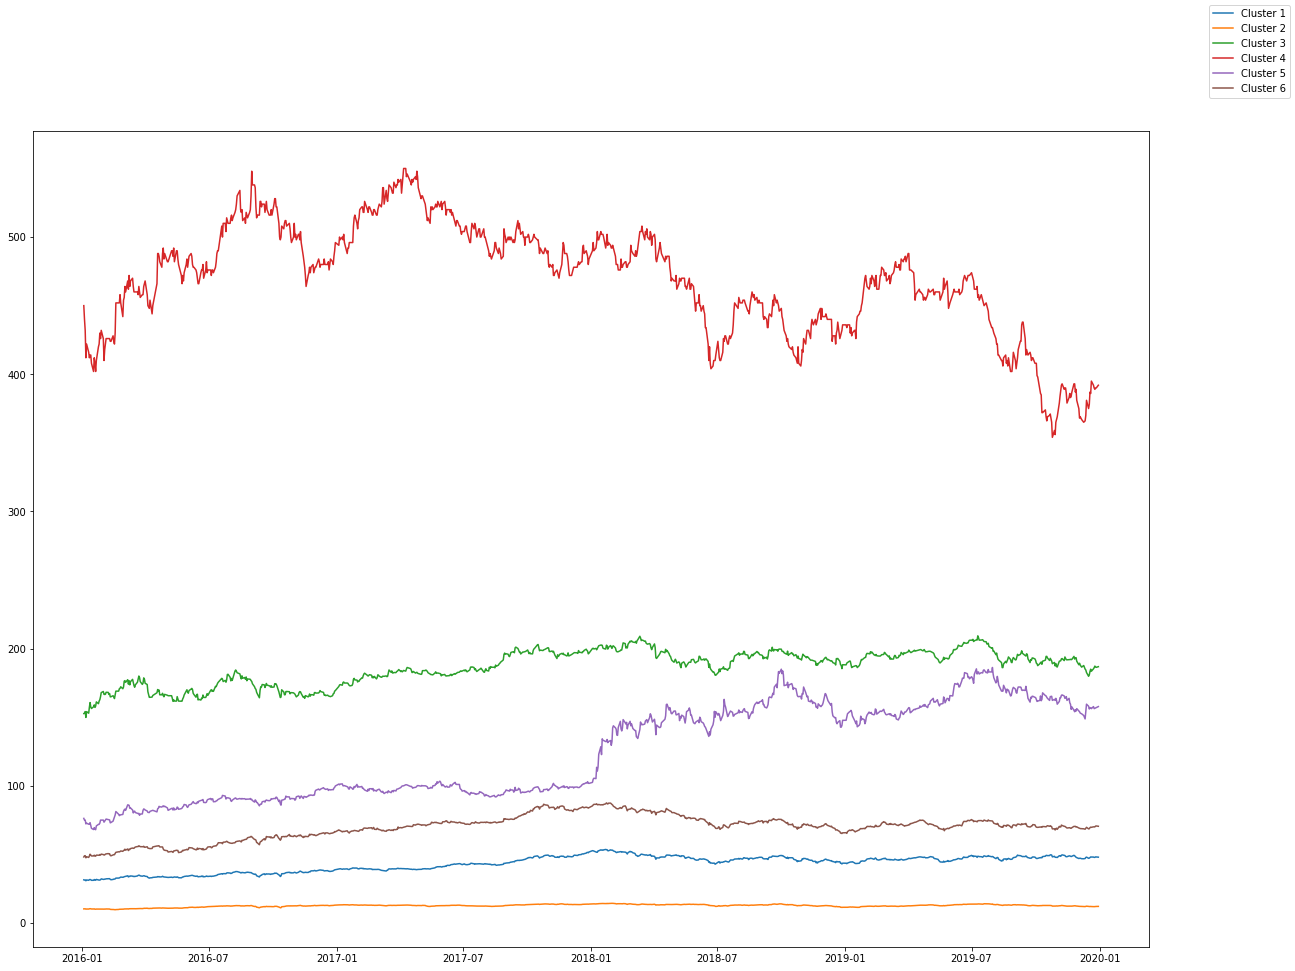

In [ ]:
all_window = all_windows['calinski_harabasz_score']['silhouette_score'] 

fig, axs = plt.subplots(3, 2) 
fig_all, ax_all = plt.subplots()

x = range(100) 

n_cluster = len(all_window['labels']) 

plot_index_i = []
plot_index_j = []

for i in range( ( n_cluster + 1) // 2 ): 
    for j in range(2):
        plot_index_i.append(i)
        plot_index_j.append(j)

plot_index = stock_data_filtered[0].index

for i, label in enumerate(all_window['labels']): 
    cluster_data = []
    for stock in label:
        stock_data = stock_data_filtered[stock_list_filtered.index(stock)]['Close']
        axs[plot_index_i[i], plot_index_j[i]].plot(stock_data)
        cluster_data.append(stock_data) 
    
    cluster_data_avg = np.average(np.array(cluster_data), axis=0)
        
    # axs[plot_index_i[i], plot_index_j[i]].plot(plot_index, cluster_data_avg, label='Cluster {:}'.format(i+1))
    # axs[plot_index_i[i], plot_index_j[i]].legend()
    ax_all.plot(plot_index, cluster_data_avg, label='Cluster {:}'.format(i+1))

fig_all.legend()
fig.set_size_inches(20, 15)
fig_all.set_size_inches(20, 15)
fig.show()
fig_all.show()

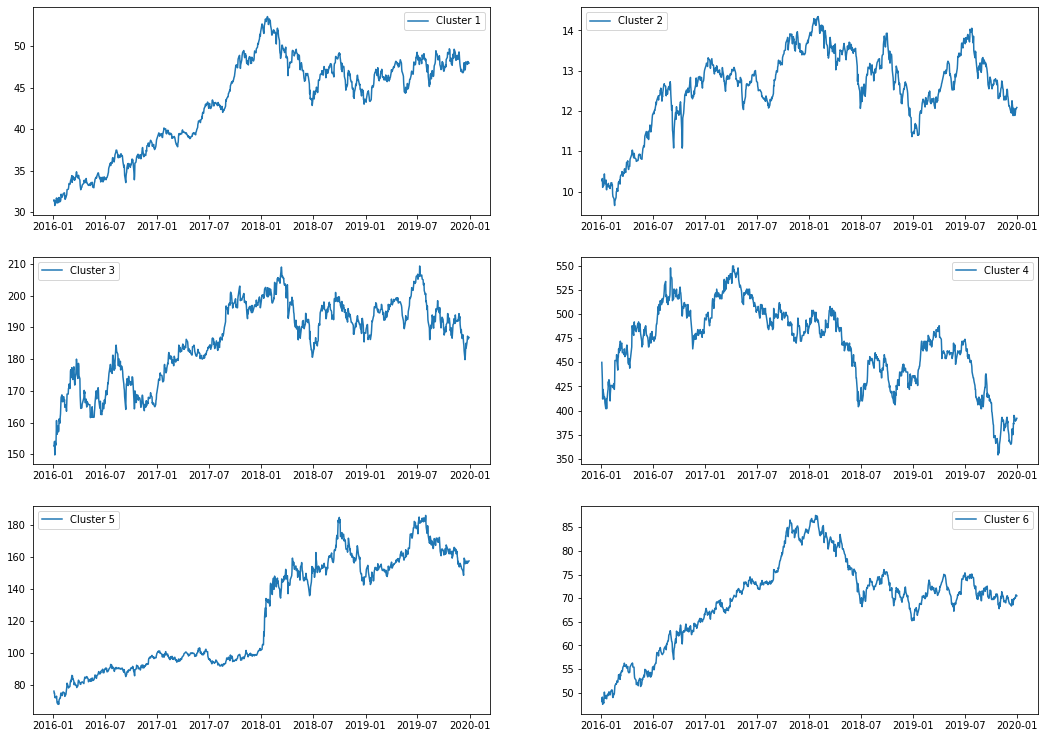

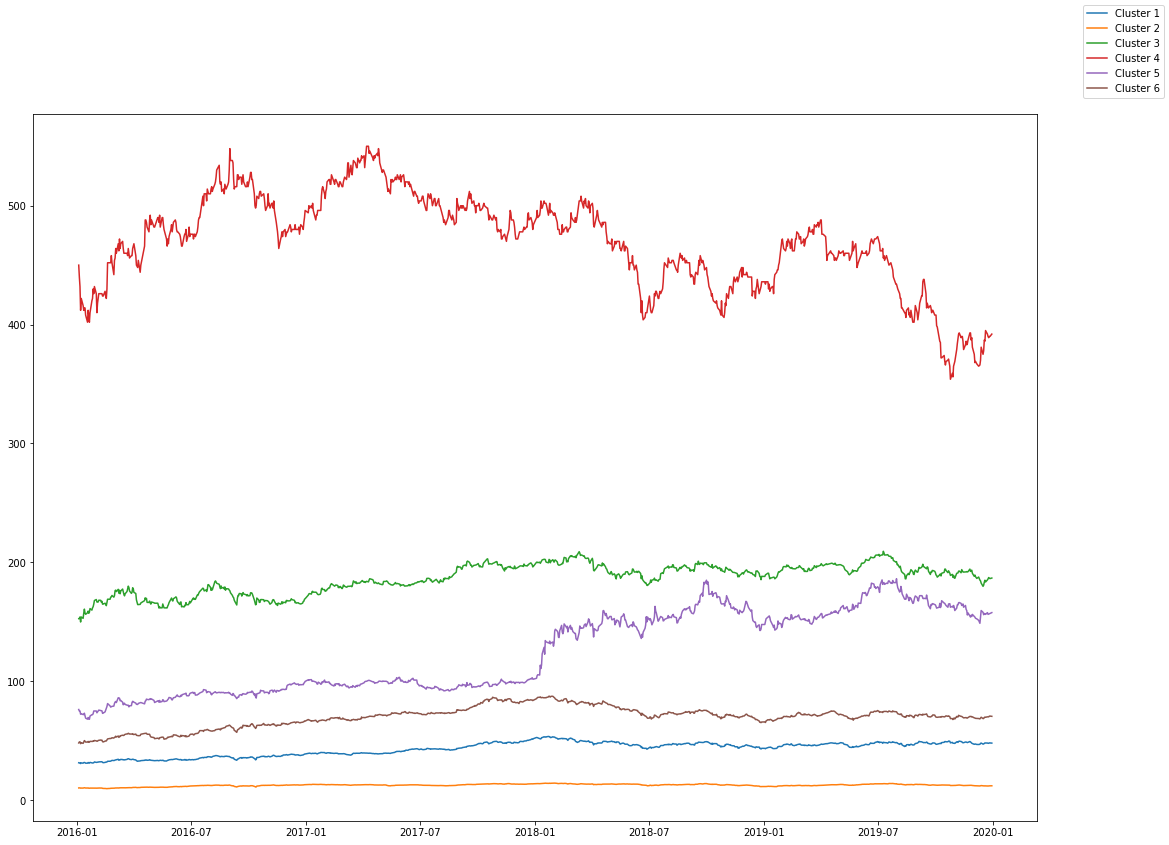

In [ ]:
all_window = all_windows['calinski_harabasz_score']['silhouette_score'] 

fig, axs = plt.subplots(3, 2) 
fig_all, ax_all = plt.subplots()

x = range(100) 

n_cluster = len(all_window['labels']) 

plot_index_i = []
plot_index_j = []

for i in range( ( n_cluster + 1) // 2 ): 
    for j in range(2):
        plot_index_i.append(i)
        plot_index_j.append(j)

plot_index = stock_data_filtered[0].index

for i, label in enumerate(all_window['labels']): 
    cluster_data = []
    for stock in label:
        stock_data = stock_data_filtered[stock_list_filtered.index(stock)]['Close']
        # axs[plot_index_i[i], plot_index_j[i]].plot(stock_data)
        cluster_data.append(stock_data) 
    
    cluster_data_avg = np.average(np.array(cluster_data), axis=0)
        
    axs[plot_index_i[i], plot_index_j[i]].plot(plot_index, cluster_data_avg, label='Cluster {:}'.format(i+1))
    axs[plot_index_i[i], plot_index_j[i]].legend()
    ax_all.plot(plot_index, cluster_data_avg, label='Cluster {:}'.format(i+1))

fig_all.legend()
fig.set_size_inches(18, 13)
fig_all.set_size_inches(18, 13)
fig.show()
fig_all.show()

In [ ]:
# fig, axs = plt.subplots(2)
# fig.suptitle('Vertically stacked subplots')
# axs[0].plot(x, y)
# axs[1].plot(x, -y)

In [ ]:
all_window = all_windows['calinski_harabasz_score']['silhouette_score'] 
matrix = new_matrix['calinski_harabasz_score']['silhouette_score']

n_cluster = len(all_window['labels'])

corr_mat = np.full((n_cluster, n_cluster), 1, dtype=float)

for i in range(n_cluster):
    for j in range(i+1, n_cluster):
        c1 = all_window['labels'][i]
        c2 = all_window['labels'][j]
        corrs = []
        for s1 in c1:
            for s2 in c2:
                index_s1 = stock_list_filtered.index(s1)
                index_s2 = stock_list_filtered.index(s2)
                corrs.append(matrix[index_s1][index_s2])
        corr = np.mean(corrs)
        corr_mat[i][j] = corr
        corr_mat[j][i] = corr

In [ ]:
labels = ['cluster {:}'.format(i+1) for i in range(n_cluster)]
Similar_matrix_btw_cluster = pd.DataFrame(corr_mat, columns=labels, index=labels)
Similar_matrix_btw_cluster

,cluster 1,cluster 2,cluster 3,cluster 4,cluster 5,cluster 6
cluster 1,1.000000,0.123688,0.000000,0.000000,0.015152,0.296717
cluster 2,0.123688,1.000000,0.000000,0.000000,0.000000,0.011809
cluster 3,0.000000,0.000000,1.000000,0.015152,0.181818,0.005682
cluster 4,0.000000,0.000000,0.015152,1.000000,0.000000,0.000000
cluster 5,0.015152,0.000000,0.181818,0.000000,1.000000,0.301136
cluster 6,0.296717,0.011809,0.005682,0.000000,0.301136,1.000000


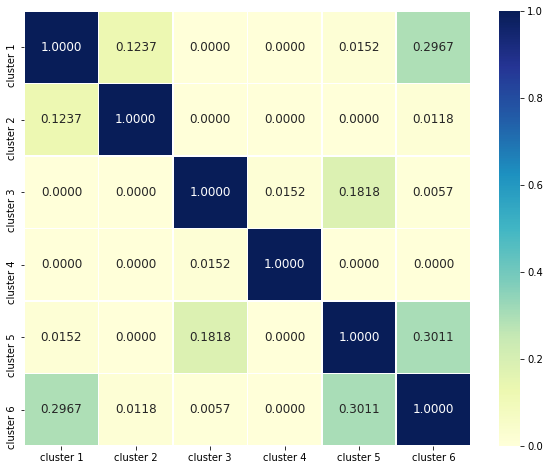

In [ ]:
import numpy as np
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(Similar_matrix_btw_cluster, annot=True, linewidths=.5, cmap="YlGnBu", fmt=".4f",annot_kws={'size':12}, ax = ax)

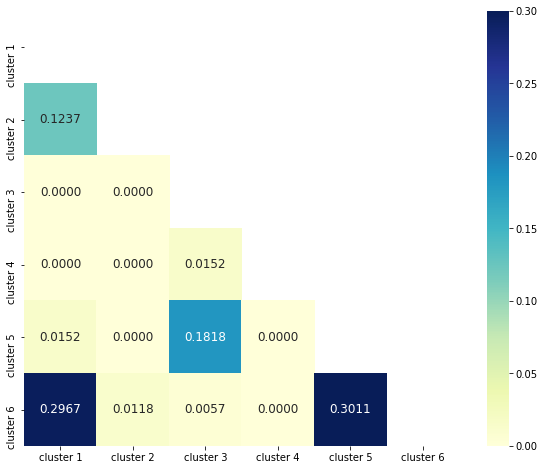

In [ ]:
mask = np.zeros_like(Similar_matrix_btw_cluster)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(Similar_matrix_btw_cluster, mask=mask, annot=True, vmax=.3, square=True, cmap="YlGnBu", fmt=".4f",annot_kws={'size':12},ax = ax)

In [ ]:
all_window = all_windows['calinski_harabasz_score']['silhouette_score'] 
matrix = new_matrix['calinski_harabasz_score']['silhouette_score']

n_stocks = len(stock_list_filtered)

corr_mat = np.full((n_stocks, n_stocks), 1, dtype=float)

sorted_stock_by_cluster = [label for cluster in all_window['labels'] for label in cluster]

for i in range(n_stocks):
    for j in range(i+1, n_stocks):
        s1 = sorted_stock_by_cluster[i]
        s2 = sorted_stock_by_cluster[j]
        index_s1 = stock_list_filtered.index(s1)
        index_s2 = stock_list_filtered.index(s2)
        corr = matrix[index_s1][index_s2]
        corr_mat[i][j] = corr
        corr_mat[j][i] = corr

In [ ]:
Similar_matrix_btw_cluster = pd.DataFrame(corr_mat, columns=sorted_stock_by_cluster, index=sorted_stock_by_cluster)
Similar_matrix_btw_cluster

,AOT,BCP,BJC,CENTEL,DTAC,EA,GPSC,HANA,INTUCH,IVL,KCE,MEGA,MINT,MTC,PTT,RATCH,SAWAD,TCAP,AMATA,AP,BANPU,BCH,BDMS,BEC,BEM,BTS,CHG,CK,CKP,COM7,CPF,EPG,ERW,ESSO,GFPT,GLOBAL,GUNKUL,HMPRO,IRPC,JAS,...,ORI,PLANB,PSL,PTG,QH,RS,SGP,SPALI,SPRC,STA,STEC,STPI,SUPER,TASCO,THAI,THANI,TKN,TMB,TRUE,TTW,TU,VGI,WHA,ADVANC,BBL,BH,EGCO,KBANK,SCB,SCC,AEONTS,PTTEP,CBG,CPALL,CPN,DELTA,KKP,PTTGC,TISCO,TOP
AOT,1.000000,0.454545,0.454545,0.545455,0.727273,0.636364,0.909091,0.454545,0.454545,0.636364,0.272727,0.363636,0.636364,0.636364,0.636364,0.454545,0.727273,0.636364,0.000000,0.000000,0.000000,0.000000,0.272727,0.181818,0.000000,0.000000,0.000000,0.363636,0.000000,0.000000,0.363636,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.181818,0.000000,0.000000,0.000000,0.363636,0.000000,0.090909,0.363636,0.000000,0.000000,0.272727,0.181818,0.000000,0.181818,0.000000,0.000000,0.000000,0.272727,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.090909,0.454545,0.636364,0.545455,0.454545,0.636364,0.545455,0.545455,0.545455
BCP,0.454545,1.000000,0.636364,0.909091,0.727273,0.818182,0.545455,1.000000,0.454545,0.818182,0.727273,0.909091,0.818182,0.636364,0.818182,0.454545,0.727273,0.636364,0.272727,0.181818,0.181818,0.181818,0.545455,0.363636,0.181818,0.181818,0.181818,0.545455,0.181818,0.272727,0.636364,0.181818,0.181818,0.181818,0.181818,0.181818,0.181818,0.181818,0.181818,0.181818,...,0.181818,0.181818,0.181818,0.363636,0.181818,0.181818,0.181818,0.545455,0.181818,0.272727,0.545455,0.181818,0.181818,0.454545,0.363636,0.181818,0.363636,0.181818,0.181818,0.181818,0.454545,0.181818,0.181818,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.272727,0.090909,0.000000,0.090909,0.090909,0.000000,0.090909,0.000000
BJC,0.454545,0.636364,1.000000,0.727273,0.727273,0.818182,0.545455,0.636364,0.818182,0.818182,0.727273,0.545455,0.818182,0.636364,0.818182,0.818182,0.727273,0.818182,0.090909,0.000000,0.000000,0.000000,0.181818,0.090909,0.000000,0.000000,0.000000,0.181818,0.000000,0.090909,0.272727,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.181818,0.000000,0.000000,0.181818,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.636364,0.454545,0.363636,0.272727,0.454545,0.363636,0.454545,0.363636
CENTEL,0.545455,0.909091,0.727273,1.000000,0.818182,0.909091,0.636364,0.909091,0.545455,0.909091,0.636364,0.818182,0.909091,0.727273,0.909091,0.545455,0.818182,0.727273,0.181818,0.090909,0.090909,0.090909,0.454545,0.272727,0.090909,0.090909,0.090909,0.454545,0.090909,0.181818,0.545455,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,...,0.090909,0.090909,0.090909,0.272727,0.090909,0.090909,0.090909,0.454545,0.090909,0.181818,0.454545,0.090909,0.090909,0.363636,0.272727,0.090909,0.272727,0.090909,0.090909,0.090909,0.363636,0.090909,0.090909,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.363636,0.181818,0.090909,0.181818,0.181818,0.090909,0.181818,0.090909
DTAC,0.727273,0.727273,0.727273,0.818182,1.000000,0.909091,0.818182,0.727273,0.727273,0.909091,0.545455,0.636364,0.909091,0.909091,0.909091,0.727273,1.000000,0.909091,0.000000,0.000000,0.000000,0.000000,0.272727,0.181818,0.000000,0.000000,0.000000,0.363636,0.000000,0.000000,0.363636,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.181818,0.000000,0.000000,0.000000,0.363636,0.000000,0.090909,0.363636,0.000000,0.000000,0.272727,0.181818,0.000000,0.181818,0.000000,0.000000,0.000000,0.272727,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.545455,0.363636,0.272727,0.181818,0.363636,0.272727,0.272727,0.272727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

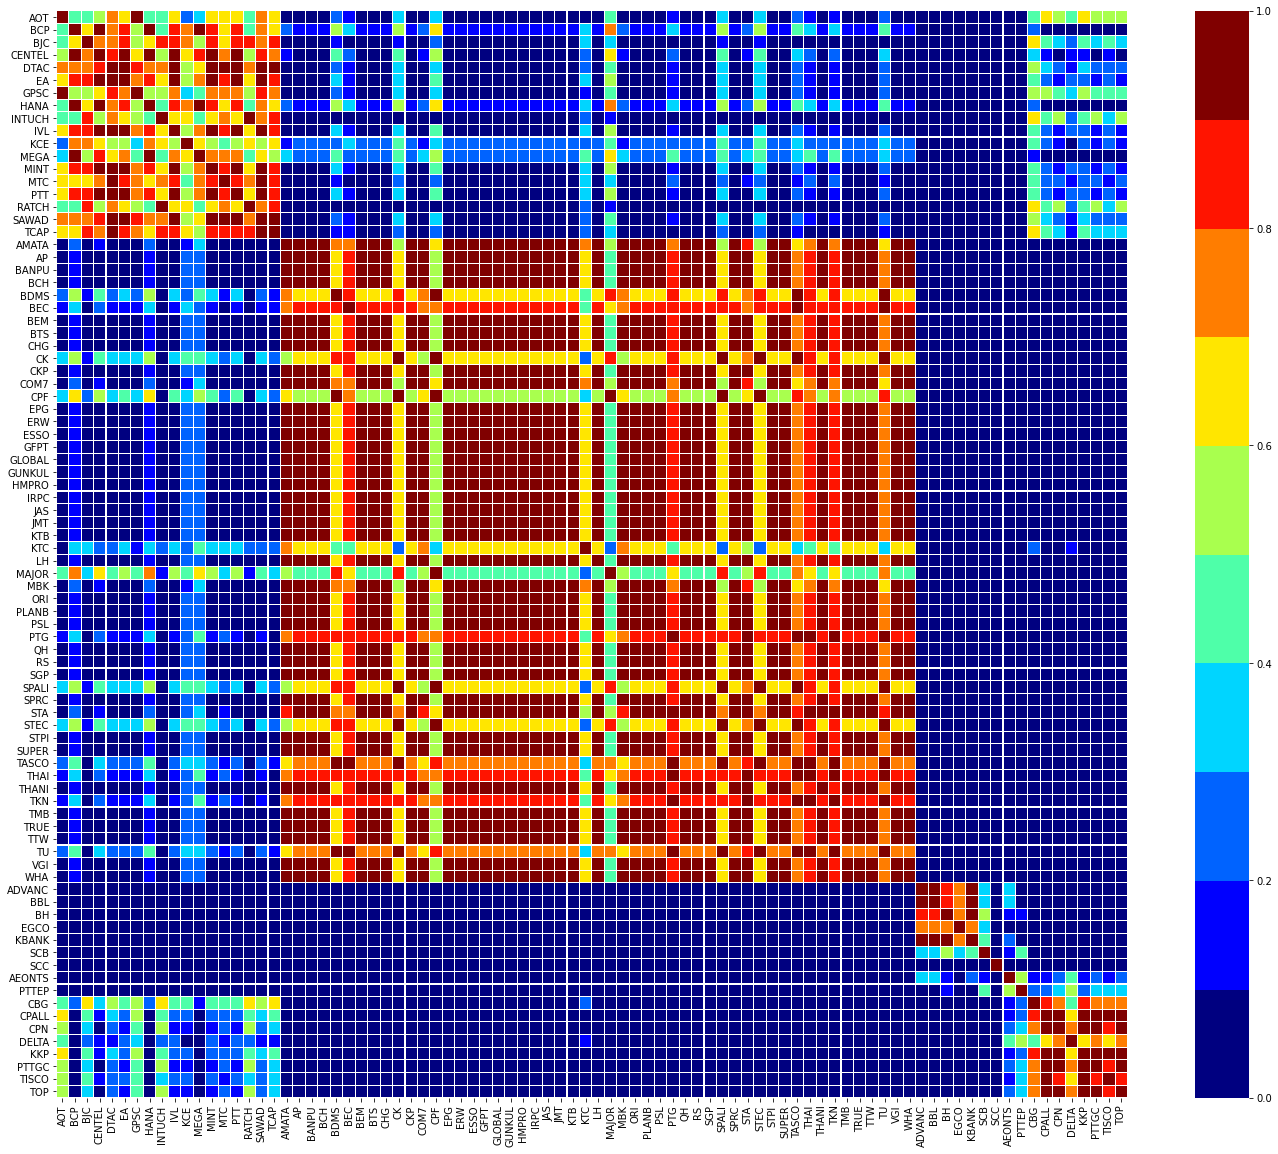

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib import pyplot as PLT
from matplotlib import cm as CM

fig, ax = plt.subplots(figsize=(24,20))
cmap = CM.get_cmap('jet', 10)
sns.heatmap(Similar_matrix_btw_cluster,annot_kws={'size':8},linewidths=.1, cmap=cmap)


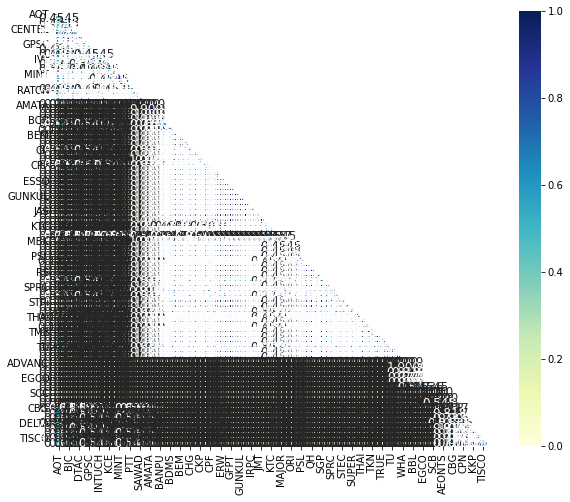

In [ ]:
mask = np.zeros_like(Similar_matrix_btw_cluster)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(Similar_matrix_btw_cluster, mask=mask, annot=True, vmax=1, square=True, cmap="YlGnBu", fmt=".4f",annot_kws={'size':12},ax = ax)

## 5.Calculate Risk-Return

In [ ]:
all_window = all_windows['calinski_harabasz_score']['silhouette_score'] 

return_risk_table = []
P = 0.5

for cluster in all_window['labels']:
    cluster_returns = []
    cluster_risks = []
    cluster_risks_normal = []
    for stock in cluster:
        stock_index = stock_list_filtered.index(stock)
        values = stock_data_filtered[stock_index]['Close'].values
        stock_returns = [(values[i+1] - values[i]) / values[i+1] * 100 for i in range(len(values)-1)]
        stock_return = np.mean(stock_returns)
        stock_risk = np.sqrt(sum([ P*((r - stock_return)**2) for r in stock_returns ]))
        # cluster_risks_normals = [(values[i+1] - stock_return) / stock_risk for i in range(len(values)-1)]
        # stock_return = np.mean(cluster_risks_normals)



        cluster_returns.append(stock_return)
        cluster_risks.append(stock_risk)
        # cluster_risks.append(cluster_risks_normal)

    cluster_return = np.mean(cluster_returns)
    cluster_risk = np.mean(cluster_risks)
    # cluster_risk = np.mean(cluster_risks_normal)
    return_risk_table.append((cluster_return, cluster_risk))



In [ ]:
SV_BTW_Cluster = pd.DataFrame(return_risk_table, columns=['Return', 'Risk'], index=labels)
SV_BTW_Cluster

,Return,Risk
cluster 1,0.021273,42.105280
cluster 2,-0.000934,45.686023
cluster 3,0.006878,30.231903
cluster 4,-0.020430,24.692522
cluster 5,0.057591,42.268636
cluster 6,0.025581,37.927321


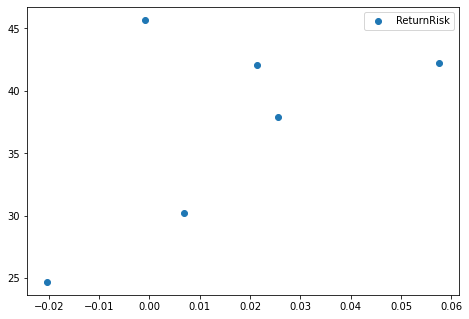

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.scatter(SV_BTW_Cluster['Return'], SV_BTW_Cluster['Risk'] , label= 'ReturnRisk')

ax.legend()

# plt.scatter(SV_BTW_Cluster[['Return', 'Risk']], SV_BTW_Cluster['SV'])
# plt.show()